In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from imblearn.over_sampling import SMOTE

from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from prettytable import PrettyTable

warnings.simplefilter('ignore')

In [34]:
df = pd.read_csv('data/winequality-red.csv', sep=';')

### Brief exploration of data

In [35]:
df.shape

(1599, 12)

In [36]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


##### Points to note:
1. No variables have missing values.
2. Except for target variable which is of 'int64' data type, all of the rest are 'float64' values.

In [38]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


##### Points to note:
1. Difference between the 75% value and the max value is pretty huge (considering the scale for each) for almost all variables except density and alcohol. This suggests positive skewness or outliers for most of the variables.
2. To confirm the same, we perform univariate analysis for each feature to understand their distributions.

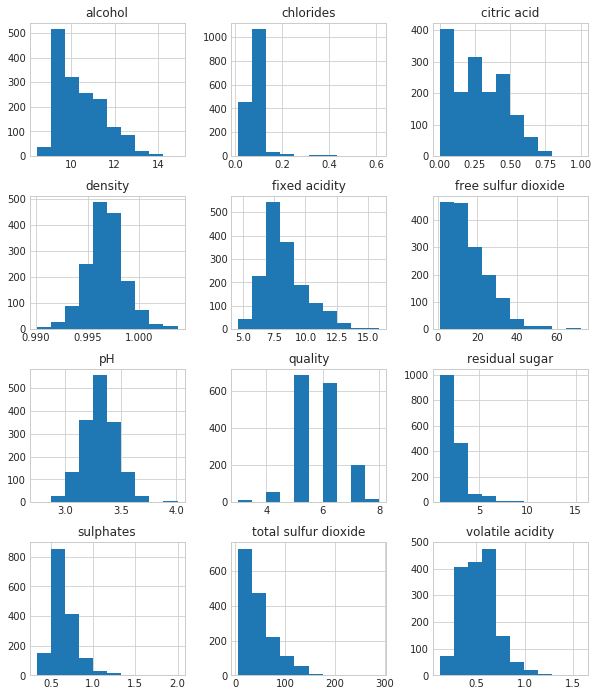

In [39]:
df.hist(figsize=(10,12))
plt.show()

##### Points to note:
1. The distribution for our <u>target variable</u> for prediction - 'quality' - suggests an imbalanced dataset.
We will confirm the same further.
2. Out of our <u>feature variables</u>, only 'density' and 'pH' distributions appear to be normally distributed. All others are positively skewed.

#### A smoother plot for our feature variables will help confirm the same.

In [40]:
names_arr = df.columns.values
f, axes = plt.subplots(1, 12, figsize=(18, 3))

for i in range(12):
    sns.distplot(df[names_arr[i]], ax=axes[i], color='green')
plt.tight_layout()

#### To check for outliers, we will have a look at their boxplots:

In [41]:
names_arr = df.columns.values
plt.figure(figsize=(15,65))

for i in range(0,12):
    plt.subplot(10, 12, i+1)
    sns.boxplot(df[names_arr[i]], orient='v')
    sns.set_style('whitegrid')
    plt.tight_layout()

##### Points to note:
1. Except for citric acid, all feature variables have plenty of outliers.

#### Let us finally have a look at the correlation between the variables

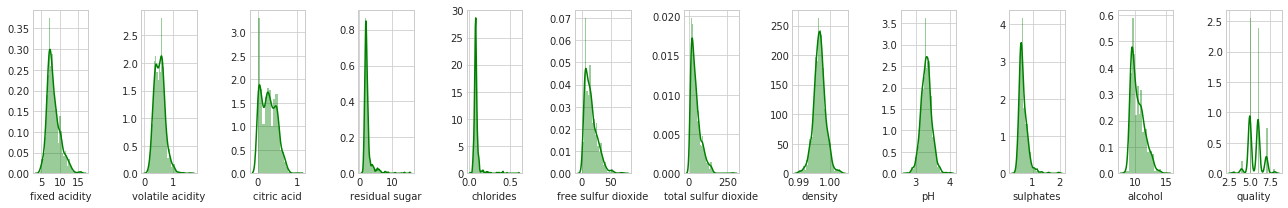

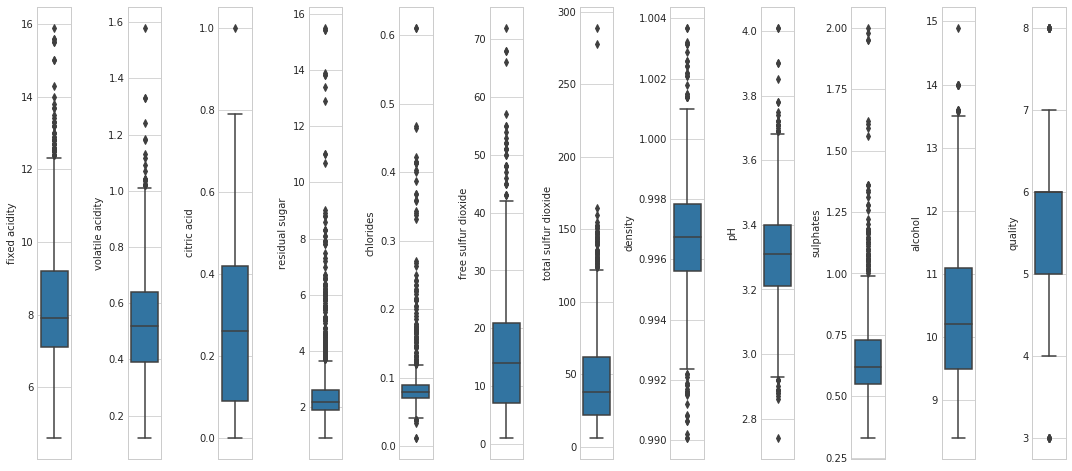

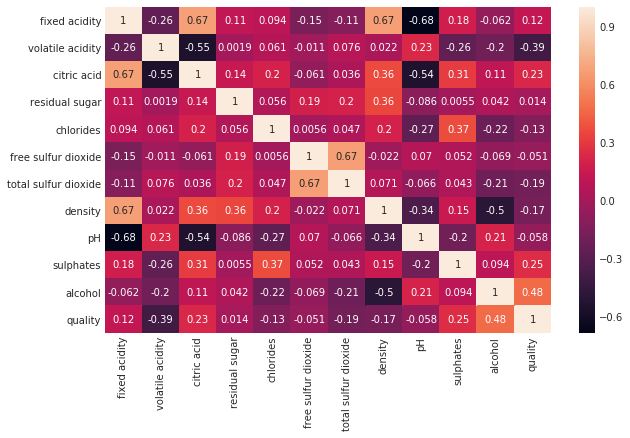

In [42]:
corr_mat = df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr_mat, annot=True)
plt.show()

#### Points to note:
<ol>
    <li>Pairs with a considerable <u>positive correlation</u> are:
        <ul>
            <li>density and fixed acidity (Magnitude = 0.67)</li>
            <li>citric acid and fixed acidity (Magnitude = 0.67)</li>
            <li>pH and citric acid (Magnitude = 0.54)</li>
            <li>free sulphur dioxide and total sulphur dioxide (Magnitude = 0.67)</li>
        </ul>
    </li>
    <br>
    <li>Pairs with a considerable <u>negative correlation</u> are:
        <ul>
            <li>pH and fixed acidity (Magnitude = 0.68)</li>
            <li>Citric acid and volatile acidity (Magnitude = 0.55)</li>
            <li>pH and citric acid (Magnitude = 0.54)</li>
            <li>density and alcohol (Magnitude = 0.5)</li>
        </ul>
    </li>
</ol>

### Predictive Analytics

#### Custom Function Definitions:

In [43]:
def print_classfication_metrics(Y_test, Y_pred):
    print("Accuracy score: ",metrics.accuracy_score(Y_test, Y_pred))
    print("\nConfusion Matrix:\n",metrics.confusion_matrix(Y_test, Y_pred))
    print("\nClassification Report:\n",metrics.classification_report(Y_test, Y_pred))

#### Important:

Problem Definition:
    
Predict whether the quality of the wine is poor, average or good based on the feature variables available.

The imbalance in the dataset w.r.t. the target variable 'quality' only allows us to label the resulting 

#### Separating the target variable from the feature variables:

In [44]:
Y = df['quality']
X = df.drop('quality', axis=1)

In [45]:
Y.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

#### Splitting the data into training and testing data:

In [46]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

#### Evaluating the classification algorithms by implementing cross validation on the <u>non-standardized</u> features:

In [47]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('SGD', SGDClassifier(penalty=None)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RFC', RandomForestClassifier(n_estimators=100)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('NB', GaussianNB()))

In [48]:
print("\nModels trained on non-standardized features:\n")
t = PrettyTable(['Model Name', 'Mean Accuracy', 'Std. Dev in the 10 Scores', 'Coeff. of Variation'])
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=2)
    cv_scores = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    #print(name," is ",cv_scores,"\n")
    t.add_row([name, round(cv_scores.mean(), 5), round(cv_scores.std(), 5), round(cv_scores.std()/cv_scores.mean(), 5)])
print(t)


Models trained on non-standardized features:

+------------+---------------+---------------------------+---------------------+
| Model Name | Mean Accuracy | Std. Dev in the 10 Scores | Coeff. of Variation |
+------------+---------------+---------------------------+---------------------+
|     LR     |    0.57858    |          0.03069          |       0.05304       |
|    SGD     |    0.42618    |          0.09662          |       0.22671       |
|    CART    |    0.62546    |          0.04531          |       0.07245       |
|    RFC     |    0.68569    |          0.01147          |       0.01673       |
|    KNN     |    0.51607    |          0.02829          |       0.05481       |
|    SVM     |    0.57002    |          0.03172          |       0.05565       |
|     NB     |    0.54578    |          0.03822          |       0.07003       |
+------------+---------------+---------------------------+---------------------+


In [49]:
print("\nModels trained on standardized features:\n")
t = PrettyTable(['Model Name', 'Mean Accuracy', 'Std. Dev in the 10 Scores', 'Coeff. of Variation'])
for name, model in models:
    pipeline = make_pipeline(preprocessing.StandardScaler(), model)
    kfold = model_selection.KFold(n_splits=10, random_state=3)
    scaled_cv_scores = model_selection.cross_val_score(pipeline, X_train, Y_train, cv=kfold, scoring="accuracy")
    t.add_row([name, round(scaled_cv_scores.mean(), 5), round(scaled_cv_scores.std(), 5), round(scaled_cv_scores.std()/scaled_cv_scores.mean(), 5)])
print(t)


Models trained on standardized features:

+------------+---------------+---------------------------+---------------------+
| Model Name | Mean Accuracy | Std. Dev in the 10 Scores | Coeff. of Variation |
+------------+---------------+---------------------------+---------------------+
|     LR     |    0.58095    |           0.0233          |       0.04012       |
|    SGD     |    0.50432    |          0.03847          |       0.07629       |
|    CART    |     0.6161    |          0.03646          |       0.05917       |
|    RFC     |    0.69196    |          0.03077          |       0.04446       |
|    KNN     |    0.57234    |          0.02056          |       0.03593       |
|    SVM     |    0.63099    |          0.03479          |       0.05513       |
|     NB     |    0.54107    |          0.03186          |       0.05888       |
+------------+---------------+---------------------------+---------------------+


In [50]:
rfc = RandomForestClassifier(n_estimators=100)

In [51]:
rfc.fit(X_train, Y_train)
rfc_pred = rfc.predict(X_test)
print_classfication_metrics(Y_test, rfc_pred)

Accuracy score:  0.69375

Confusion Matrix:
 [[  0   0   2   0   0   0]
 [  0   0   6   5   0   0]
 [  0   0 103  33   0   0]
 [  0   0  24  98   6   0]
 [  0   0   1  18  21   0]
 [  0   0   0   2   1   0]]

Classification Report:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.76      0.76      0.76       136
           6       0.63      0.77      0.69       128
           7       0.75      0.53      0.62        40
           8       0.00      0.00      0.00         3

    accuracy                           0.69       320
   macro avg       0.36      0.34      0.34       320
weighted avg       0.67      0.69      0.68       320



In [52]:
Y_test.value_counts()

5    136
6    128
7     40
4     11
8      3
3      2
Name: quality, dtype: int64

#### Trying with SMOTE:

In [53]:
print(X_train.shape)
print(Y_train.shape)

(1279, 11)
(1279,)


In [54]:
sm = SMOTE(random_state=12)

In [55]:
X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train)

In [56]:
print(X_train.shape)
print(Y_train.shape)

(1279, 11)
(1279,)


In [57]:
print(X_train_res.shape)
print(Y_train_res.shape)

(3270, 11)
(3270,)


In [58]:
X_train_res = pd.DataFrame(X_train_res)

Y_train_res = pd.Series(Y_train_res)

In [59]:
Y_train_res.value_counts()

7    545
5    545
3    545
8    545
6    545
4    545
dtype: int64

In [60]:
rfc_smote = RandomForestClassifier(n_estimators=100)

In [70]:
rfc_smote.fit(X_train_res, Y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [71]:
rfc_smote_pred = rfc_smote.predict(X_test)

In [72]:
print_classfication_metrics(Y_test, rfc_pred)

Accuracy score:  0.69375

Confusion Matrix:
 [[  0   0   2   0   0   0]
 [  0   0   6   5   0   0]
 [  0   0 103  33   0   0]
 [  0   0  24  98   6   0]
 [  0   0   1  18  21   0]
 [  0   0   0   2   1   0]]

Classification Report:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.76      0.76      0.76       136
           6       0.63      0.77      0.69       128
           7       0.75      0.53      0.62        40
           8       0.00      0.00      0.00         3

    accuracy                           0.69       320
   macro avg       0.36      0.34      0.34       320
weighted avg       0.67      0.69      0.68       320



In [73]:
print_classfication_metrics(Y_test, rfc_smote_pred)

Accuracy score:  0.659375

Confusion Matrix:
 [[ 0  1  1  0  0  0]
 [ 0  4  5  2  0  0]
 [ 1 10 96 26  3  0]
 [ 0  3 21 83 17  4]
 [ 0  2  1  8 28  1]
 [ 0  0  0  1  2  0]]

Classification Report:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.20      0.36      0.26        11
           5       0.77      0.71      0.74       136
           6       0.69      0.65      0.67       128
           7       0.56      0.70      0.62        40
           8       0.00      0.00      0.00         3

    accuracy                           0.66       320
   macro avg       0.37      0.40      0.38       320
weighted avg       0.68      0.66      0.67       320

